# Aiyagari model using EGM and PDF approximation


**Caution!!!**

This code stil has some bug. Now I'm trying to fix it.

In this notebook, we solve Aiyagari model using endogenous gridpoint method and probability density function approximation.

EGM part is based on my previous code which is included in PE_EGM.ipynb.

PDF approximation Algorithm is based on Heer and Maussner.

These two may work. However, left tail of distribution is not smooth. 
- I think this is caused by max(min(searchsoredlast)) part.


Due to these phenomenona, I cannot say with confidence that this code works well and has no problem.

If you find some error, please let me know.


In [1]:
#using Interpolations
using Plots
using QuantEcon
gr()

Plots.GRBackend()

In [2]:
include("myrouwenhorst.jl")
include("Aggregate_Labor.jl")

Aggregate_Labor (generic function with 1 method)

In [3]:
struct Model
    β::Float64 
    μ::Float64
    b::Float64
    α::Float64
    δ::Float64
    zgrid::Array{Float64,1}
    Π::Array{Float64,2}
    L::Float64
end

In [4]:
#Set params
β = 0.96
μ = 3.0
b = 0.0
α = 0.36
δ = 0.08


# create shock grid
σ  = 0.4 #standard deviation of error_t
ρ = 0.3
nz = 7 # number of grid 
zgrid,Π = myrouwenhorst(nz,ρ,σ)
zgrid = exp.(zgrid)

# compute labor supply
L = Aggregate_Labor(zgrid,Π)

model = Model(β,μ,b,α,δ,zgrid,Π,L)

Model(0.96, 3.0, 0.0, 0.36, 0.08, [0.358042, 0.504223, 0.710087, 1.0, 1.40828, 1.98325, 2.79297], [0.0754189 0.243661 … 0.0204835 0.00183827; 0.0406102 0.184754 … 0.033539 0.00341392; … ; 0.00341392 0.033539 … 0.184754 0.0406102; 0.00183827 0.0204835 … 0.243661 0.0754189], 1.091427039471635)

In [21]:
function main(m::Model)
    #primitive parameter
    const β = m.β #0.96 #subjective discount factor
    const μ = m.μ # relative risk aversion
    const b = m.b #0.0 # debt limit
    const α = m.α #0.36 # capital share
    const δ = m.δ #0.08 # delta
    
    # utility function
    u(c::Float64) = c^(1.0-μ)/(1.0-μ)
    u′(c::Float64) = c^(-μ)
    u′_inv(val::Float64) = val^(-1.0/μ)
    
    #discretize indivisual shock
    zgrid = m.zgrid
    Π　= m.Π
    const nz = size(zgrid,1)

    #aggregate labor
    const L = m.L

    # create asset grid
    const na = 500
    const a2min = 1e-5 
    const a2max = 30.0
    a2grid = collect(linspace(a2min,a2max,na))
    const fna = 2000
    agrid_fine = collect(linspace(a2min,a2max,fna))#zeros(fna)
  
    # for convenience
    a2mat = repmat(a2grid,1,nz)  
    temp = repmat(zgrid ,1,na)
    zmat = temp'
    
    # initialize asset matrices 
    amat = zeros(na,nz)  # asset grid (we compute  it later) range [a2min-ϕ, a2max-ϕ]
    a1= zeros(na,nz) # today's asset + ϕ
    wealth = zeros(na,nz) # wealth matrix
    

    # initialize consumption matrices
    c1 = zeros(na,nz) # consumption matrix in this period
    c2 = zeros(na,nz)  # consumption matrix in the next period
    EMU = zeros(na,nz) # expected marginal utility matrix in the next period
    
    # initialize policy functions 
    pol_c = zeros(na,nz) # policy function for consumption
    pol_a = zeros(na,nz) # policy function for asset
    pol_a = 0.5 * a2mat # initial guess of policy function 
    new_pol_a =zeros(na,nz) # updated policy
    
    
    # initialize probability density function
    Λ0 = ones(fna,nz)./(fna*nz)
    #Λ0 = zeros(fna, nz)
    #Λ0[1,1] = 1.0 # initial guess of probability density function.
    Λ1 = zeros(fna,nz) # store new density function
    
    #iteration setting
    const maxiter = 3000
    const tol = 1e-3 # GE loop
    const dp_tol = 1e-5 # DP loop
    const dist_tol = 1e-8 # distribution loop
    const small = 1e-13
    it =0
    err_k = 10.0
    
    # itinial guess
    K0 = 6.0
    
    #########################################################################
    # 1. GE loop
    ##########################################################################
    while err_k > tol
          
        # compute factor price
        r0 = α*((L/K0)^(1.0-α)) -δ
        w0 = (1.0-α)*((K0/L)^α)
        wealth = (1.0+r0)*a2mat + w0*zmat -r0*b
        
        ########################################################################
        # 2. Solving indivisual problem
        ########################################################################
        
        for it in 1:maxiter
        
            c2 = wealth - pol_a 
            # replace negative consumption with very small number
            @views c2[c2.<small] = small 
            
            EMU = u′.(c2)*Π' 
            # generate today's consumption by Euler equation
            @. c1 = u′_inv(β*(1.0+r0)*EMU)

            # budget constraint: c + a' = (1+r)a + w*z 
            # rearranging this as
            # c + a' +ϕ = (1+r)(a+ϕ) +w*z -r*ϕ
        
            # compute endogenous asset matrix
            a1 .=((c1+a2mat) - w0*zmat + b*r0)./(1.0+r0)
            
            # update new policy function
            @inbounds for i in 1:nz
                 @views pol_itp = LinInterp((1.0+r0)*a1[:,i]+ w0*zgrid[i] -r0*b, a2grid)
                 @views new_pol_a[:,i] = pol_itp.(wealth[:,i])
            end
            
            # replace extrapolation with lower bound.
            #@views new_pol_a[new_pol_a.<a2min] = a2min 
            err = maximum(abs.(new_pol_a-pol_a))
            pol_a =copy(new_pol_a)
               
            if err < dp_tol
                # amat[:,1] is the asset grid that we consider 
                #@views  amat = (wealth - w0*zmat -b)./(1.0+r0)
                #agrid_fine =  collect(linspace(amat[1,1],amat[end,1],fna))
                pol_c = wealth- pol_a
                break
            end
        
        end
        ##################################################################################
        # End of indivisual problem
        ##################################################################################
        
        ###################################################################################
        # 3. Compute invariant distribution
        ###################################################################################
        
        
        # Method: computing invariant probability density function.
        
        # step 1: 
        # Set fine grid ... Already done!  agrid_fine  
        
        # step 2: 
        # Choose initial density function Λ0 already done! 
        
        # step 3: 
        # Set Λ1 =0 for all z and a. Already done!
        
        # step 4:
        # Compute invariant probability density function until it converges
        # This is what we do in the following code
        # Algorithm is based on Heer and Maussner pp.351~352
        
       
        #pol_itp = interpolate((a2grid,zgrid),pol_a ,Gridded(Linear()))
        i_k::Int64 = 0
        
        # Start loop
        for density_iter in 1 : maxiter
            
            @inbounds for (i_z, v_z) in enumerate(zgrid)
                pol_itp = LinInterp(a2grid,pol_a[:,i_z])
                @inbounds for (i_a, v_a) in enumerate(agrid_fine)
                   
                    # This procedure may not be appropriate, I think.
                    # Need to be fixed.
                    i_k =max(min(searchsortedlast(agrid_fine, pol_itp(v_a)), fna-1), 1)
                   
                    #if pol_itp(v_a) > agrid_fine[i_k+1]
                    #    println(pol_itp(v_a))
                    #    println(agrid_fine[i_k+1])
                    #    error("searchsortedlast does not work, upper")
                    #end
                    #if pol_itp(v_a) < agrid_fine[i_k]
                    #    error("searchsortedlast does not work, lower")
                    #end
                        
                    d = agrid_fine[i_k+1] - agrid_fine[i_k]

                    # この fractionがなぜかnegativeになる分母は悪くないので分子の問題
                    value = pol_itp(v_a)
                    if pol_itp(v_a) > a2max
                        value = a2max
                    elseif pol_itp(v_a) < a2min
                        value = a2min
                    end
                    frac = (value-agrid_fine[i_k])/d
                    if frac > 1.0
                        error("test")
                    elseif frac <0.0
                        error("test2")
                    end

                    @inbounds for i_nextz in 1: nz
                        Λ1[i_k,i_nextz] += (1.0-frac) *Λ0[i_a,i_z]*Π[i_z,i_nextz]　
                        Λ1[i_k+1,i_nextz] += frac *Λ0[i_a,i_z]*Π[i_z,i_nextz]　
                    end
                end
            end

            density_err = maximum(abs.(Λ0-Λ1))
            Λ0 = copy(Λ1)
            Λ1 = zeros(fna,nz)
                    
            # Check convergence.
            if density_err < dist_tol
                break
            end
        end
        
        #############################################################
        # End of computing invariant distribution 
        #############################################################
        
        ############################################################
        # 4. Aggregation
        ############################################################
        K1 = 0.0
        for j in 1:fna 
            for z in 1: nz
            @inbounds K1 += agrid_fine[j]* Λ0[j,z]
            end
        end
        
        # update aggregate capital
        K0 = 0.9*K0 +0.1*K1
        
        # update error 
        err_k = abs(K0-K1)
        
        it +=1
        if it >= maxiter
            println("the model cannot converge in $maxiter times iteration")
            break
        end
    end

    return a2grid,agrid_fine,K0, L, Λ0, pol_a, pol_c
end

main (generic function with 1 method)

In [22]:
agrid, agrid_fine ,K, L,dist0, pol_a,pol_c  = main(model) 

([1.0e-5, 0.0601302, 0.12025, 0.180371, 0.240491, 0.300611, 0.360731, 0.420852, 0.480972, 0.541092  …  29.4589, 29.519, 29.5792, 29.6393, 29.6994, 29.7595, 29.8196, 29.8798, 29.9399, 30.0], [1.0e-5, 0.0150175, 0.030025, 0.0450325, 0.06004, 0.0750475, 0.090055, 0.105062, 0.12007, 0.135077  …  29.8649, 29.8799, 29.8949, 29.91, 29.925, 29.94, 29.955, 29.97, 29.985, 30.0], 6.494076057104659, 1.091427039471635, [4.71905e-5 0.00019032 … 2.87297e-5 2.86392e-6; 1.57223e-5 7.67346e-5 … 2.23213e-5 2.51963e-6; … ; 2.82017e-9 2.56633e-8 … 1.0521e-7 2.28156e-8; 4.76689e-8 4.42504e-7 … 2.13056e-6 5.01006e-7], [1.0e-5 1.0e-5 … 1.1547 2.03803; 1.0e-5 1.0e-5 … 1.2105 2.09572; … ; 28.9286 29.0833 … 30.0 30.0; 28.9869 29.1411 … 30.0 30.0], [0.435455 0.613242 … 1.25736 1.35882; 0.497678 0.675465 … 1.26378 1.36335; … ; 2.49387 2.51698 … 3.3991 4.38389; 2.49787 2.52144 … 3.46133 4.44611])

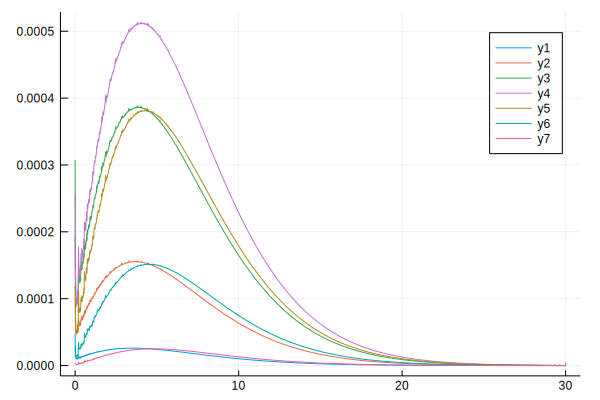

In [23]:
plot(agrid_fine, dist0)

Since I don't extrapolation, policy function hits the maximum value of grid. 
However, this doesn't matter since these households in the economy  are very few.

In addition, we must not use extrapolation in this code. 
Since computation of invariant distribution consider the probability, extrapolation violates the axiom of probability.

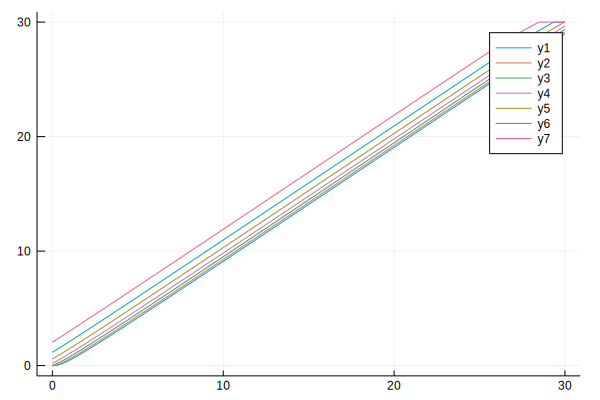

In [8]:
plot(agrid,pol_a)

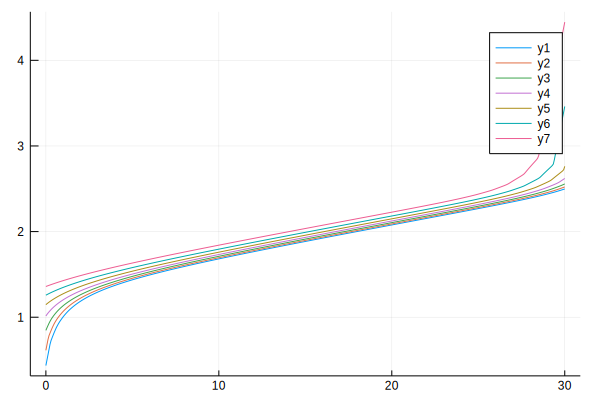

In [9]:
plot(agrid,pol_c)